In [16]:
# | default_exp model.sdm_trend_forecaster

In [17]:
# | export
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [21]:
# | export

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


def detect_period_from_states(states, min_period=1, max_period=None):
    """
    Detect periodicity in state sequence using FFT.
    
    Args:
        states: Array of state assignments.
        min_period: Minimum period to consider.
        max_period: Maximum period to consider.
    
    Returns:
        int or None: Detected period or None if no clear period.
    """
    n = len(states)
    if max_period is None:
        max_period = max(1, n // 2)
    x = states.astype(float) - np.mean(states)
    fft = np.fft.rfft(x)
    ps = np.abs(fft) ** 2
    ps[0] = 0  # ignore DC
    k = np.argmax(ps[1:]) + 1
    if ps[k] <= 1e-6:
        return None
    period = int(round(n / k))
    if period < min_period or (max_period and period > max_period):
        return None
    return period


def extend_state_sequence(seg_states, horizon_segments, period=None, recent_segments=10):
    """
    Forecast future states using a weighted Markov chain, prioritizing recent transitions.
    
    Args:
        seg_states: Array of historical states (length n_segments).
        horizon_segments: Number of future segments to forecast.
        period: Detected period (if any) to use as fallback.
        recent_segments: Number of recent segments to emphasize.
    
    Returns:
        Array of forecasted states (length horizon_segments).
    """
    if period is not None and period >= 1 and len(seg_states) >= period:
        cycle = seg_states[-period:]
        seq = []
        while len(seq) < horizon_segments:
            seq.extend(cycle[: min(len(cycle), horizon_segments - len(seq))])
        return np.array(seq[:horizon_segments], dtype=int)

    unique_states = np.unique(seg_states)
    n_states = max(len(unique_states), 1)
    max_state = max(unique_states) if len(unique_states) > 0 else 0
    trans_counts = np.zeros((max_state + 1, max_state + 1))
    gamma = 1 - 1 / max(1, recent_segments)
    epsilon = 0.01

    if len(seg_states) > 1 and len(unique_states) > 1:
        for t in range(len(seg_states) - 1):
            weight = gamma ** (len(seg_states) - 2 - t)
            i = seg_states[t]
            j = seg_states[t + 1]
            trans_counts[i, j] += weight
    else:
        print("Warning: Insufficient state transitions; using uniform transitions")
        trans_counts = np.ones((max_state + 1, max_state + 1)) / (max_state + 1)

    trans_mat = np.zeros_like(trans_counts)
    for i in range(max_state + 1):
        row_sum = np.sum(trans_counts[i]) + (max_state + 1) * epsilon
        trans_mat[i] = (trans_counts[i] + epsilon) / row_sum

    seq = []
    current_state = seg_states[-1] if len(seg_states) > 0 else 0
    for _ in range(horizon_segments):
        next_state = np.argmax(trans_mat[current_state])
        seq.append(next_state)
        current_state = next_state
    return np.array(seq, dtype=int)


def create_segments(residuals, n_segments, min_seg_len, N):
    """
    Divide residuals into equally spaced segments.
    
    Args:
        residuals: Array of residuals.
        n_segments: Number of segments.
        min_seg_len: Minimum segment length.
        N: Length of residuals.
    
    Returns:
        segments: List of segment arrays.
        bounds: List of (start, end) indices.
        seg_len: Length of each segment.
    """
    max_allowed_segments = max(1, N // min_seg_len)
    n_segments = min(n_segments, max_allowed_segments)
    seg_len = N // n_segments
    segments = []
    bounds = []
    for i in range(n_segments):
        start = i * seg_len
        end = (i + 1) * seg_len if i < n_segments - 1 else N
        seg = residuals[start:end]
        segments.append(seg)
        bounds.append((start, end))
    return segments, bounds, seg_len


def extract_features(segments):
    """
    Extract features (mean, slope, std) for each segment.
    
    Args:
        segments: List of segment arrays.
    
    Returns:
        features: Array of shape (n_segments, 3) with mean, slope, std.
    """
    features = []
    for seg in segments:
        t = np.arange(len(seg))
        mean = float(np.mean(seg)) if len(seg) > 0 else 0.0
        std = float(np.std(seg)) if len(seg) > 0 else 0.0
        slope = float(np.polyfit(t, seg, 1)[0]) if len(seg) >= 2 else 0.0
        features.append([mean, slope, std])
    return np.asarray(features)


def fit_piecewise_linear_trend(t, y, n_changepoints=5, forecast_horizon=0):
    """
    Fit a piecewise linear trend with optional forecasting.
    
    Args:
        t: Time indices (0 to N-1).
        y: Time series values.
        n_changepoints: Number of change points for piecewise linear trend.
        forecast_horizon: Number of future points to forecast.
    
    Returns:
        fitted: Fitted values for historical period.
        forecast: Forecasted values for future period (if forecast_horizon > 0).
    """
    N = len(y)
    t = np.asarray(t)
    y = np.asarray(y)
    
    # Detect change points based on slope changes
    slopes = np.diff(y) / np.diff(t)
    slope_changes = np.abs(np.diff(slopes))
    if len(slope_changes) < n_changepoints:
        changepoints = np.linspace(0, N-1, n_changepoints + 2)[1:-1].astype(int)
    else:
        changepoints = np.argsort(slope_changes)[-n_changepoints:] + 1
        changepoints = np.sort(changepoints)
    
    # Add start and end points
    changepoints = np.concatenate([[0], changepoints, [N-1]])
    
    # Fit linear segments
    fitted = np.zeros(N)
    for i in range(len(changepoints) - 1):
        start, end = changepoints[i], changepoints[i + 1]
        if end > start:
            t_seg = t[start:end + 1]
            y_seg = y[start:end + 1]
            coeffs = np.polyfit(t_seg, y_seg, 1)
            fitted[start:end + 1] = np.polyval(coeffs, t_seg)
    
    # Forecast
    forecast = []
    if forecast_horizon > 0:
        last_segment = changepoints[-2:]
        t_last = t[last_segment[0]:last_segment[1] + 1]
        y_last = y[last_segment[0]:last_segment[1] + 1]
        coeffs = np.polyfit(t_last, y_last, 1)
        t_future = np.arange(N, N + forecast_horizon)
        forecast = np.polyval(coeffs, t_future)
    
    return fitted, np.array(forecast)


class SDMTrendForecaster:
    """A class for forecasting time series using a custom trend fit and HMM."""
    
    def __init__(
        self,
        n_states=3,
        min_seg_len=3,
        requested_n_segments=30,
        forecast_horizon_ratio=0.2,
        recent_segments=10,
        seed=42,
        n_changepoints=5
    ):
        """
        Initialize the forecaster.
        
        Args:
            n_states: Number of HMM states.
            min_seg_len: Minimum segment length.
            requested_n_segments: Desired number of segments.
            forecast_horizon_ratio: Fraction of series length for forecast horizon.
            recent_segments: Number of recent segments for weighted Markov chain.
            seed: Random seed for reproducibility.
            n_changepoints: Number of change points for piecewise linear trend.
        """
        self.n_states = n_states
        self.min_seg_len = min_seg_len
        self.requested_n_segments = requested_n_segments
        self.forecast_horizon_ratio = forecast_horizon_ratio
        self.recent_segments = recent_segments
        self.seed = seed
        self.n_changepoints = n_changepoints
        self.trend = None
        self.dates = None
        self.residuals = None
        self.segments = None
        self.bounds = None
        self.seg_len = None
        self.features = None
        self.seg_states = None
        self.state_timeline = None
        self.state_residual_means = None
        self.trend_hist = None
        self.trend_future = None
        self.combined_hist = None
        self.combined_future = None
        self.future_dates = None
        self.period = None
    
    def prepare_data(self, trend, dates=None):
        """
        Prepare input data and validate.
        
        Args:
            trend: Input time series.
            dates: Optional date index; if None, generated from today.
        """
        self.trend = np.asarray(trend).astype(float).flatten()
        N = len(self.trend)
        if N < 20:
            raise ValueError("trend too short; need at least ~20 points")
        
        if dates is None:
            start_date = pd.Timestamp.today().normalize() - pd.Timedelta(days=N - 1)
            self.dates = pd.date_range(start=start_date, periods=N, freq="D")
        else:
            self.dates = pd.to_datetime(dates)
            if len(self.dates) != N:
                raise ValueError("dates length must match trend length")
        
        self.forecast_horizon = max(1, int(self.forecast_horizon_ratio * N))
    
    def fit_trend(self):
        """Fit a piecewise linear trend and compute residuals."""
        t = np.arange(len(self.trend))
        self.trend_hist, self.trend_future = fit_piecewise_linear_trend(
            t, self.trend, n_changepoints=self.n_changepoints, forecast_horizon=self.forecast_horizon
        )
        self.residuals = self.trend - self.trend_hist
        self.future_dates = pd.date_range(
            self.dates[-1] + pd.Timedelta(days=1), periods=self.forecast_horizon, freq="D"
        )
    
    def segment_residuals(self):
        """Divide residuals into segments."""
        self.segments, self.bounds, self.seg_len = create_segments(
            self.residuals, self.requested_n_segments, self.min_seg_len, len(self.trend)
        )
        if len(self.segments) < self.n_states + 1:
            n_segments = min(self.n_states + 1, max(1, len(self.trend) // self.min_seg_len))
            print(f"Warning: Adjusted n_segments to {n_segments} to ensure sufficient transitions")
            self.segments, self.bounds, self.seg_len = create_segments(
                self.residuals, n_segments, self.min_seg_len, len(self.trend)
            )
    
    def extract_segment_features(self):
        """Extract features from segments."""
        self.features = extract_features(self.segments)
        print("Features shape:", self.features.shape)
    
    def fit_hmm(self):
        """Fit HMM to segment features."""
        scaler = StandardScaler()
        X = scaler.fit_transform(self.features)
        print("Feature std per column:", np.std(X, axis=0))
        if np.any(np.std(X, axis=0) < 1e-6):
            print("Warning: Low feature variability detected; adding noise to features")
            X += np.random.randn(*X.shape) * 1e-3
        
        hmm = GaussianHMM(
            n_components=self.n_states,
            covariance_type="diag",
            n_iter=500,
            random_state=self.seed,
            init_params="stmc"
        )
        hmm.startprob_ = np.ones(self.n_states) / self.n_states
        hmm.transmat_ = np.ones((self.n_states, self.n_states)) / self.n_states
        hmm.means_ = np.random.randn(self.n_states, X.shape[1]) * 0.1
        hmm.covars_ = np.ones((self.n_states, X.shape[1]))
        
        try:
            hmm.fit(X)
            self.seg_states = hmm.predict(X)
        except Exception as e:
            print(f"HMM fitting failed: {e}. Falling back to k-means clustering.")
            kmeans = KMeans(n_clusters=self.n_states, random_state=self.seed)
            self.seg_states = kmeans.fit_predict(X)
        
        self.seg_states = np.clip(self.seg_states, 0, self.n_states - 1)
        print("Assigned states:", np.unique(self.seg_states, return_counts=True))
        
        # Map states to timeline
        self.state_timeline = np.zeros(len(self.trend), dtype=int)
        for s, (start, end) in zip(self.seg_states, self.bounds):
            self.state_timeline[start:end] = s
        
        # Compute state residual means
        self.state_residual_means = []
        for s in range(self.n_states):
            idx = np.where(self.seg_states == s)[0]
            if idx.size:
                self.state_residual_means.append(np.mean(self.features[idx, 0]))
            else:
                self.state_residual_means.append(0.0)
        self.state_residual_means = np.asarray(self.state_residual_means)
    
    def detect_periodicity(self):
        """Detect periodicity in state sequence."""
        self.period = detect_period_from_states(
            self.seg_states, min_period=2, max_period=len(self.seg_states) // 2
        )
        print("Detected state period (segments):", self.period)
    
    def forecast_states(self):
        """Forecast future states."""
        horizon_segments = int(np.ceil(self.forecast_horizon / self.seg_len))
        self.future_seg_states = extend_state_sequence(
            self.seg_states, horizon_segments, period=self.period, recent_segments=self.recent_segments
        )
        
        self.future_state_timeline = []
        for s in self.future_seg_states:
            self.future_state_timeline.extend([s] * self.seg_len)
        self.future_state_timeline = np.array(self.future_state_timeline[:self.forecast_horizon], dtype=int)
    
    def combine_forecasts(self):
        """Combine trend with state residual offsets."""
        self.combined_hist = self.trend_hist + self.state_residual_means[self.state_timeline]
        self.combined_future = self.trend_future + self.state_residual_means[self.future_state_timeline]
    
    def plot_results(self):
        """Plot observed, fitted, and forecasted series with state shading."""
        plt.figure(figsize=(14, 6))
        plt.plot(self.dates, self.trend, color="k", lw=1.2, label="Observed")
        plt.plot(self.dates, self.trend_hist, color="tab:blue", lw=1.0, label="Trend fit")
        plt.plot(
            self.dates[-self.forecast_horizon:],
            self.combined_hist[-self.forecast_horizon:],
            color="tab:gray",
            lw=0.8,
            alpha=0.8,
            label="Hist combined (trend + state effect)",
        )
        
        # Shaded HMM states over history
        for i, (s, (start, end)) in enumerate(zip(self.seg_states, self.bounds)):
            plt.axvspan(self.dates[start], self.dates[end - 1], color=plt.get_cmap("tab10")(s), alpha=0.12)
        
        # Shaded HMM states for forecasted segments
        future_bounds = []
        for i in range(len(self.future_seg_states)):
            start = i * self.seg_len
            end = min((i + 1) * self.seg_len, self.forecast_horizon)
            future_bounds.append((start, end))
        for i, (s, (start, end)) in enumerate(zip(self.future_seg_states, future_bounds)):
            plt.axvspan(
                self.future_dates[start],
                self.future_dates[end - 1] if end < self.forecast_horizon else self.future_dates[-1],
                color=plt.get_cmap("tab10")(s),
                alpha=0.12,
            )
        
        plt.plot(self.future_dates, self.trend_future, "r--", lw=2, label="Trend forecast")
        plt.plot(
            self.future_dates, self.combined_future, "r-", lw=2, label="Combined forecast (trend + state effect)"
        )
        
        plt.title("Piecewise linear trend + HMM state-effect forecasting (weighted Markov states)")
        plt.legend()
        plt.xlabel("date")
        plt.tight_layout()
        plt.show()
    
    def fit(self, trend, dates=None):
        """
        Fit the forecasting model.
        
        Args:
            trend: Input time series.
            dates: Optional date index.
        """
        self.prepare_data(trend, dates)
        self.fit_trend()
        self.segment_residuals()
        self.extract_segment_features()
        self.fit_hmm()
        self.detect_periodicity()
        self.forecast_states()
        self.combine_forecasts()
    
    def predict(self):
        """Return historical and future combined forecasts."""
        return self.combined_hist, self.combined_future
    
    def print_diagnostics(self):
        """Print diagnostic information."""
        print("N points:", len(self.trend))
        print("Segments:", len(self.segments), "seg_len (approx):", self.seg_len)
        print("Detected state period:", self.period)
        print("Recent segments weighted (x):", self.recent_segments)
        print("State residual means (per-state):", np.round(self.state_residual_means, 6))



In [22]:
## Example usage 

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


Features shape: (30, 3)
Feature std per column: [1. 1. 1.]
Assigned states: (array([0, 1, 2]), array([ 1, 14, 15]))
Detected state period (segments): 6
N points: 100
Segments: 30 seg_len (approx): 3
Detected state period: 6
Recent segments weighted (x): 10
State residual means (per-state): [-0.219407 -0.031774  0.042739]


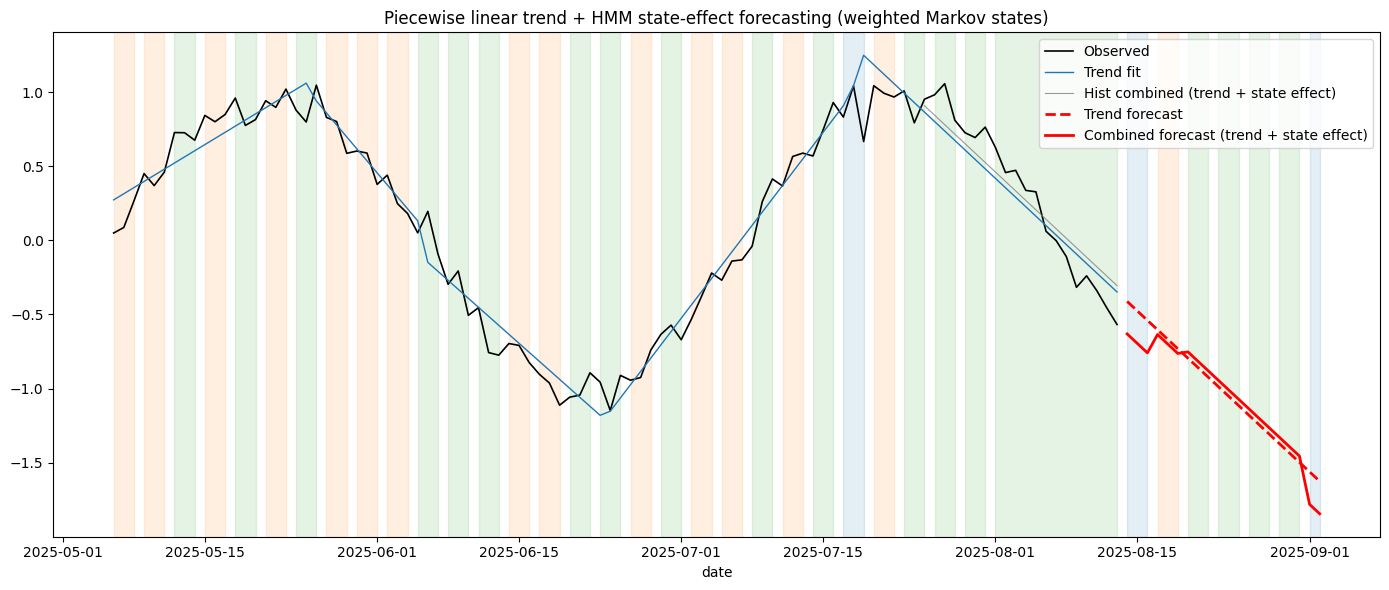

In [25]:
from ts.model.sdm_trend_forecaster import SDMTrendForecaster
if __name__ == "__main__":
    # Example usage
    np.random.seed(42)
    trend = np.sin(np.linspace(0, 10, 100)) + np.random.randn(100) * 0.1
    forecaster = SDMTrendForecaster(
        n_states=3,
        min_seg_len=3,
        requested_n_segments=30,
        forecast_horizon_ratio=0.2,
        recent_segments=10,
        seed=42,
        n_changepoints=5
    )
    forecaster.fit(trend.flatten())
    forecaster.print_diagnostics()
    forecaster.plot_results()

In [30]:
trend.shape,forecaster.combined_future.shape

((100,), (20,))